Data driven KPI with DNN as basis and system model $K_{f,g,h}$ found using data

In [ ]:
%%capture
!pip install deeptime

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# import deeptime as dt
# from scipy.integrate import odeint
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers

In [ ]:
class DNN_AE(Model):
    def __init__(self, input_dim, output_dim):
        super(DNN_AE, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_dim), name="inputs"),
            # Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
            Dense(128, activation='tanh'),
            Dense(128, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            Dense(output_dim, name="lifted_states"),
        ])
        self.decoder = tf.keras.Sequential([
            Input(shape=(output_dim), name="inputs"),
            tf.keras.layers.Dropout(0.2),
            Dense(128, activation='tanh'),
            Dense(128, activation='tanh'),
            #  Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
            Dense(input_dim)
        ])

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def state_derivative(x, u, w):

    xdot = np.zeros(2)
    xdot[0] = -x[0] + x[1] + 0.1* w[0]
    xdot[1] = -0.5*(x[0]+x[1]) + 0.5*(x[0]**2)*x[1] + x[0]*u[0] + 0.5*x[1]*w[0]

    return xdot


def control_law(x, x_lifted, R, G_x, gamma, H_x, LQR=True, V=0):
    u = np.zeros(1)
    w = np.zeros(1)

    if LQR: 
        u[0] = 0
        w[0] = 0
    else:
        u[0] = -0.5 * R * x_lifted.T @ G_x @ V
        w[0] = (0.5 * gamma**2) * x_lifted.T @ H_x @ V

    cost = - x.T @ x - R * u[0]**2 + (1/gamma**2) * w[0]**2

    return u, w, cost


def RK4(x, u, w, dt): 
    K1 = state_derivative(x, u, w)
    K2 = state_derivative(x + K1 * dt / 2, u, w)
    K3 = state_derivative(x + K2 * dt / 2, u, w)
    K4 = state_derivative(x + K3 * dt, u, w)

    x_next = x + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt

    return x_next


def get_random_data(x_domain, u_domian, w_domain, samples, tstep, forced=True, adversary=True):

    x_dataset = (x_domain[0] - x_domain[1]) * np.random.random_sample((2, samples)) + x_domain[1]
    y_dataset = np.zeros((2, samples))

    if forced:
        u = (u_domain[0] - u_domain[1]) * np.random.random_sample((1, samples)) + u_domain[1]
    else:
        u = np.zeros((1,samples))

    if adversary:
        w = (w_domain[0] - w_domain[1]) * np.random.random_sample((1, samples)) + w_domain[1]
    else:
        w = np.zeros((1,samples))
    for k in range(x_dataset.shape[0]):
        # Predict state after one time step
        y_dataset[:,k] = RK4(x_dataset[:,k], u[:,k], w[:,k], tstep)

    return x_dataset, y_dataset

def learn_basis(x_dataset, y_dataset, train_percent, lr, batch_size, epochs, epsilon):
    N = x_dataset.shape[0]
    M = x_dataset.shape[1]
    input_dim = N
    K = N
    L1 = []
    num_train = int(train_percent * M)
    train_x = x_dataset[:, :num_train].T
    train_y = y_dataset[:, :num_train].T
    test_x = x_dataset[:, num_train:].T
    test_y = y_dataset[:, num_train:].T

    while True:
        output_dim = K
        print("~"*25)
        print("Lifted Dimension = ",K)
        # Train Autoencoder for lifted labels
        model_ = DNN_AE(input_dim, output_dim)
        
        lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
                    lr,
                    decay_steps=1000,
                    decay_rate=1,
                    staircase=False)
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

        model_.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay),
                                    loss = 'mse',
                                    metrics=['accuracy'])
        # Takes about 7 minutes to train
        history = model_.fit(
            train_x,
            train_x,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            verbose=0,
            validation_data = (test_x, test_x),
            callbacks = callback
            )
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Autoencoder Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper right')
        plt.show()

        K_edmd, G, A, _ = EDMD(x_dataset, y_dataset, model_)

        L1.append(np.linalg.norm(G @ K_edmd - A,'fro'))
        print('Loss L1 = ', L1[-1]) 

        if L1[-1] <= epsilon:
            print('done')
            plt.plot(L1)
            plt.title('Optimization Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['GK-A'], loc='upper right')
            plt.show()
            break

        K = K + 1

    return K_edmd, model_


def EDMD(x, y, model_):

    x_lifted = model_.encoder(x.T)
    x_lifted = x_lifted.numpy().T
    y_lifted = model_.encoder(y.T)
    y_lifted = y_lifted.numpy().T
    M = x_lifted.shape[0]
    G = np.zeros((M,M))
    A = np.zeros((M,M))

    for i in range(M):
        G = G + x_lifted[:,i] @ x_lifted[:,i].T
        A = A + x_lifted[:,i] @ y_lifted[:,i].T
    G = G/M
    A = A/M 

    K = np.linalg.pinv(G) @ A
    
    return K, G, A, x_lifted


def operator_approximation(x_domain, u_domain, w_domain, samples, tstep, train_percent, lr, batch_size, epochs, epsilon, R, gamma):
    # control and adversary response u=1, w=1 dithered
    x_K, y_K = get_random_data(x_domain, u_domain, w_domain, samples, tstep, forced=True, adversary=True)
    K_cl, model_ = learn_basis(x_K, y_K, train_percent, lr, batch_size, epochs, epsilon)

    # adversary response  u=0, w=1 dithered
    x_K0, y_K0 = get_random_data(x_domain, u_domain, w_domain, samples, tstep, forced=False, adversary=True)
    K0, _, _, _ = EDMD(x_K0, y_K0, model_)
    # control response  u=1, w=0 dithered
    x_K1, y_K1 = get_random_data(x_domain, u_domain, w_domain, samples, tstep, forced=True, adversary=False)
    K1, _, _, _ = EDMD(x_K1, y_K1, model_)
    # free response  u=0, w=0 dithered
    x_K2, y_K2 = get_random_data(x_domain, u_domain, w_domain, samples, tstep, forced=False, adversary=False)
    K2, _, _, _ = EDMD(x_K2, y_K2, model_)

    #Control Operator
    G_x = (K1-K0)/tstep
    #Adversarial Operator
    H_x = (K1-K2)/tstep

    x_lqr, y_lqr, cost_lqr = get_closed_loop_data(x_domain, samples, tstep, model_, R, G_x, gamma, H_x, LQR=True, V=0)
    K_init, _, _, x_lifted = EDMD(x_lqr, y_lqr, model_)
    Psi_inv = np.linalg.pinv(x_lifted)
    b = Psi_inv.T @ cost_lqr.T
    L_init = (K_init - np.eye(x_lifted.shape[0])) / tstep
    V_init = np.linalg.pinv(L_init) @ b

    return V_init, G_x, H_x, model_


def get_closed_loop_data(x_domain, samples, tstep, model_, R, G_x, gamma, H_x, LQR=True, V=0):

    x_dataset = (x_domain[0] - x_domain[1]) * np.random.random_sample((2, samples)) + x_domain[1]
    y_dataset = np.zeros((2, samples))
    x_lifted = model_.encoder(x_dataset.T)
    x_lifted = x_lifted.numpy().T
    total_cost = []
    if LQR:
        for k in range(samples):
            u, w, cost = control_law(x_dataset[:,k], x_lifted[:,k], R, G_x, gamma, H_x, LQR=True, V=0)
            total_cost.append(cost)
            # Predict state after one time step
            y_dataset[:,k] = RK4(x_dataset[:,k], u, w, tstep)
    else:
        for k in range(samples):
            u, w, cost = control_law(x_dataset[:,k], x_lifted[:,k], R, G_x, gamma, H_x, LQR, V)
            total_cost.append(cost)
            # Predict state after one time step
            y_dataset[:,k] = RK4(x_dataset[:,k], u, w, tstep)
    total_cost = np.asarray(total_cost)

    return x_dataset, y_dataset, total_cost


def get_sim_data(x_init, t, tstep, model_, R, G_x, gamma, H_x, V):
    samples = np.size(t)
    x_dataset = np.zeros((2, samples))
    y_dataset = np.zeros((2, samples))
    x_dataset[:,0] = x_init
    total_cost = []
    LQR = False

    for k in range(samples-1):
        x_lifted = model_.encoder(x_dataset.T)
        x_lifted = x_lifted.numpy().T
        u, w, cost = control_law(x_dataset[:,k], x_lifted[:,k], R, G_x, gamma, H_x, LQR, V)
        total_cost.append(cost)
        # Predict state after one time step
        y_dataset[:,k] = RK4(x_dataset[:,k], u, w, tstep)
        x_dataset[:,k+1] = y_dataset[:,k]
    total_cost = np.asarray(total_cost)

    return x_dataset, y_dataset, total_cost


def value_iteration(V_init, G_x, H_x, R, gamma, model_, nbr_V, x_domain, samples, tstep):

    V = V_init

    for i in range(nbr_V):
        x_dataset, y_dataset, total_cost = get_closed_loop_data(x_domain, samples, tstep, model_, R, G_x, gamma, H_x, LQR=False, V=V)
        K_cl, _, _, x_lifted = EDMD(x_dataset, y_dataset, model_)
        Psi_inv = np.linalg.pinv(x_lifted)
        b = Psi_inv.T @ total_cost.T
        L_init = (K_cl - np.eye(x_lifted.shape[0])) / tstep
        V = np.linalg.pinv(L_init) @ b
    
    return V



~~~~~~~~~~~~~~~~~~~~~~~~~
Lifted Dimension =  2


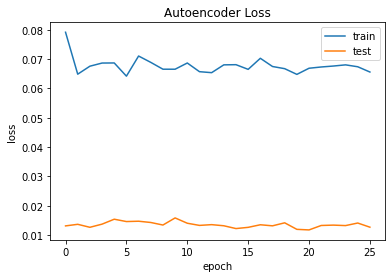

Loss L1 =  2.220446049250313e-16
done


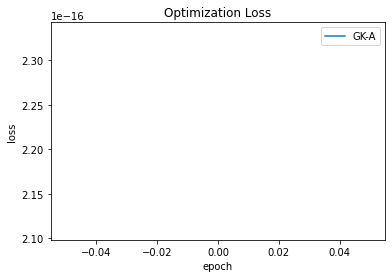

In [ ]:
x_init = np.array([0.5, 0.5]).T
x_domain = [-1,1]
u_domain = [-1,1]
w_domain = [-1,1]
samples = int(1e4)
tstep = 0.01
simulation_time = 5
t = np.arange(0,simulation_time,tstep)
lr = 1e-3
batch_size = 32
epochs = 50
epsilon = 1e-5
train_percent = 0.8
nbr_V = 15
R = 1
gamma = 5
#initial admissible control and operator identification
V_init, G_x, H_x, model_ = operator_approximation(x_domain, u_domain, w_domain, samples, tstep, train_percent, lr, batch_size, epochs, epsilon, R, gamma)
#value iteration
V = value_iteration(V_init, G_x, H_x, R, gamma, model_, nbr_V, x_domain, samples, tstep)
#simulate system
x_sim, y_sim, cost = get_sim_data(x_init, t, tstep, model_, R, G_x, gamma, H_x, V)


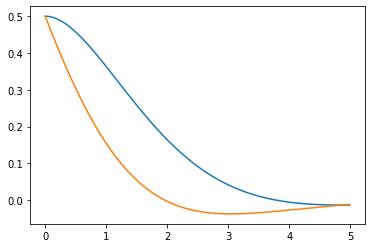

In [ ]:
plt.plot(t, x_sim[0,:])
plt.plot(t, x_sim[1,:])


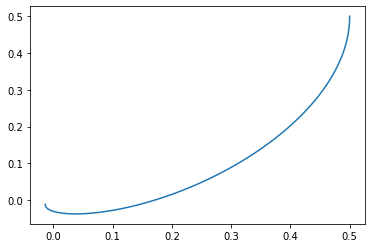

In [ ]:
plt.plot(x_sim[0,:], x_sim[1,:])


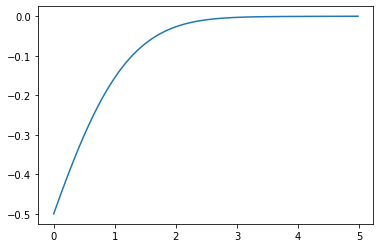

In [ ]:
plt.plot(t[:-1], cost)